In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [4]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

np_bg_SB = np.load('./data/processed/np_bg_SB_2.npy')
np_bg_SR = np.load('./data/processed/np_bg_SR_2.npy')
np_sig_SR = np.load('./data/processed/np_sig_SR_2.npy')

np_sig_SR_labeled = np.copy(np_sig_SR)
np_bg_SR_labeled = np.copy(np_bg_SR)
#add sb label
np_sig_SR_labeled = np.append(np_sig_SR_labeled,np.ones([len(np_sig_SR),1]),1)
np_bg_SR_labeled = np.append(np_bg_SR_labeled,np.zeros([len(np_bg_SR),1]),1)

np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
np_combined_SR_labeled = np.concatenate((np_sig_SR_labeled,np_bg_SR_labeled),axis=0)

gc.collect()

9

In [6]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()


In [7]:
classifier = classifier_model()
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4

Train on 235962 samples, validate on 78655 samples
Epoch 1/10
235962/235962 [==============================] - 8s 34us/sample - loss: 0.5859 - tp: 64407.0000 - fp: 30163.0000 - tn: 115318.0000 - fn: 26074.0000 - accuracy: 0.7617 - precision: 0.6811 - recall: 0.7118 - auc: 0.7970 - val_loss: 0.4070 - val_tp: 22586.0000 - val_fp: 4546.0000 - val_tn: 44141.0000 - val_fn: 7382.0000 - val_accuracy: 0.8484 - val_precision: 0.8324 - val_recall: 0.7537 - val_auc: 0.8880
Epoch 2/10
235962/235962 [==============================] - 6s 27us/sample - loss: 0.4110 - tp: 70516.0000 - fp: 17887.0000 - tn: 127594.0000 - fn: 19965.0000 - accuracy: 0.8396 - precision: 0.7977 - recall: 0.7793 - auc: 0.8850 - val_loss: 0.3885 - val_tp: 21748.0000 - val_fp: 3485.0000 - val_tn: 45202.0000 - val_fn: 8220.0000 - val_accuracy: 0.8512 - val_precision: 0.8619 - val_recall: 0.7257 - val_auc: 0.9041
Epoch 3/10
235962/235962 [==============================] - 6s 27us/sample - loss: 0.3664 - tp: 72083.0000 - fp: 1490

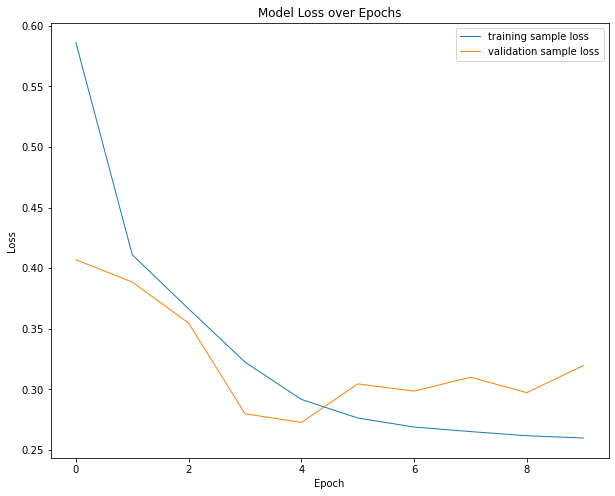

In [19]:
x_train,x_test,y_train,y_test = train_test_split(np_combined_SR_labeled[:,[2,6,7,8]],np_combined_SR_labeled[:,-1], test_size = 0.2, random_state=1) #rf label
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2, #rflabel


classifier = classifier_model()
history = classifier.fit(x_train, y_train, epochs=10, batch_size=128,validation_data=(x_val,y_val))
learningCurveLoss(history)
y_pred = classifier.predict(x_test) #predict on signal vs background in test sample
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_value = auc(fpr,tpr)


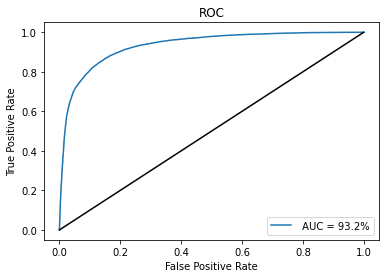

In [20]:
plot_roc_curve(y_test, y_pred)